<a href="https://colab.research.BVHle.com/github/amanjain252002/Stock-Price-Prediction/blob/main/ARIMA_Model.ipynb" target="_parent"><img src="https://colab.research.BVHle.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pmdarima matplotlib


/Users/macbook/.zshenv:1: command not found: c


In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
ACB = pd.read_csv("./Database/Pre_Processed_ACB.csv")
BIDV = pd.read_csv("./Database/Pre_Processed_BIDV.csv")
BVH = pd.read_csv("./Database/Pre_Processed_BVH.csv")
CTG = pd.read_csv("./Database/Pre_Processed_CTG.csv")
FPT = pd.read_csv("./Database/Pre_Processed_FPT.csv")

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series and help us understand if the series is stationary.

**Null Hypothesis**: The series has a unit root

**Alternate Hypothesis**: The series has no unit root.

If we fail to reject the Null Hypothesis, then the series is non-stationary.

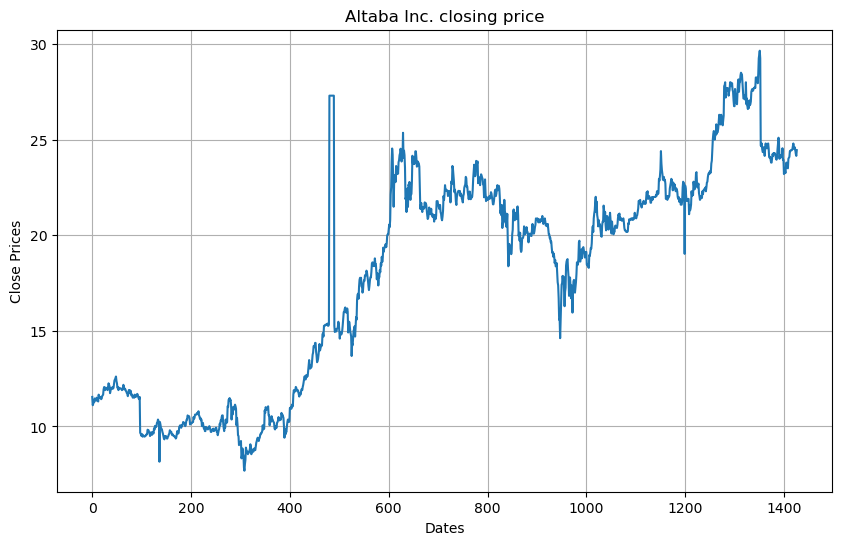

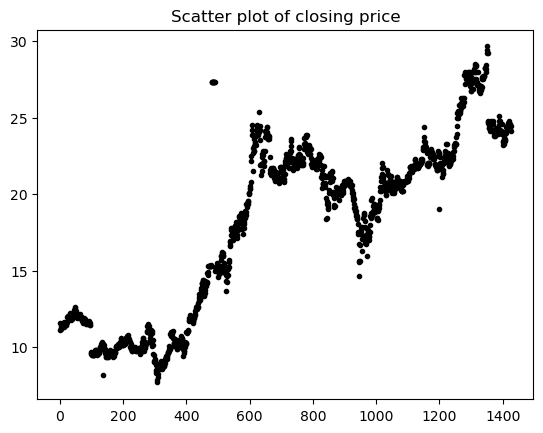

In [4]:
# Visualize the per day closing price of the stock.
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(ACB['Adj. Close'])
plt.title('Altaba Inc. closing price')
plt.show()

# Lets us plot the scatterplot:
df_close = ACB['Adj. Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

In [5]:
def Test_Stationarity(timeseries):
  result = adfuller(timeseries['Adj. Close'], autolag = 'AIC')
  print("Results of Dickey Fuller Test")
  print(f'Test Statistics: {result[0]}')
  print(f'p-value: {result[1]}')
  print(f'Number of lags used: {result[2]}')
  print(f'Number of observations used: {result[3]}')
  for key, value in result[4].items():
    print(f'critical value ({key}): {value}')

#Apple

In [6]:
ACB.head()

,Date,Open,High,Low,Adj. Close,Volume
0,2019-01-02 00:00:00,11.703,11.693,11.416,11.544,1103106.0
1,2019-01-03 00:00:00,10.398,11.360,10.267,11.110,1956382.0
2,2019-01-04 00:00:00,11.070,11.413,11.052,11.189,2771983.0
3,2019-01-07 00:00:00,11.426,11.402,11.244,11.347,1305819.0
4,2019-01-08 00:00:00,12.414,12.378,11.235,11.268,846226.0


In [7]:
ACB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427 entries, 0 to 1426
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1427 non-null   object 
 1   Open        1427 non-null   float64
 2   High        1427 non-null   float64
 3   Low         1427 non-null   float64
 4   Adj. Close  1427 non-null   float64
 5   Volume      1427 non-null   float64
dtypes: float64(5), object(1)
memory usage: 67.0+ KB


In [8]:
# Change Dtype of Date column
ACB["Date"] = pd.to_datetime(ACB["Date"])

In [9]:
Test_Stationarity(ACB)

Results of Dickey Fuller Test
Test Statistics: -1.3362107634290112
p-value: 0.612447396793636
Number of lags used: 10
Number of observations used: 1416
critical value (1%): -3.434976549531161
critical value (5%): -2.86358329808087
critical value (10%): -2.5678578416363433


The p-value > 0.05, so we cannot reject the Null hypothesis. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series, to make the data stationary while building the Auto ARIMA model.

Now let's take log of the 'Adj. Close' column to reduce the magnitude of the values and reduce the series rising trend.

Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

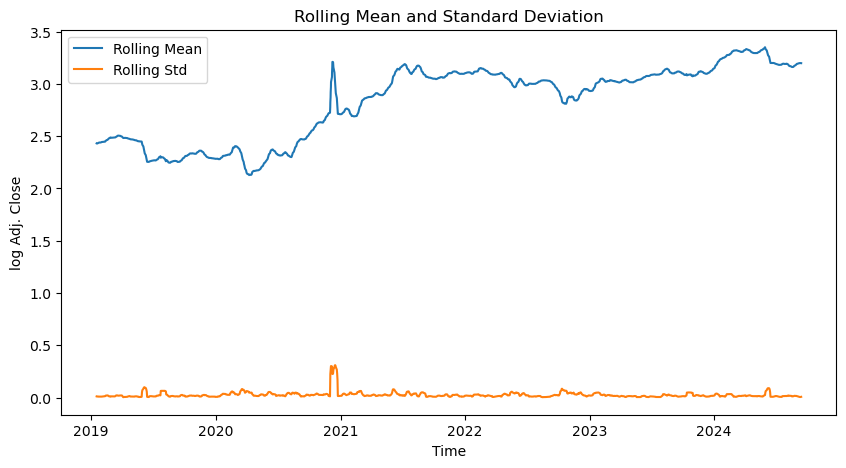

In [10]:
ACB['log Adj. Close'] = np.log(ACB['Adj. Close'])
ACB_log_moving_avg = ACB['log Adj. Close'].rolling(12).mean()
ACB_log_std = ACB['log Adj. Close'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(ACB['Date'], ACB_log_moving_avg, label = "Rolling Mean")
plt.plot(ACB['Date'], ACB_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

### Split the data into training and test set







(286, 7)


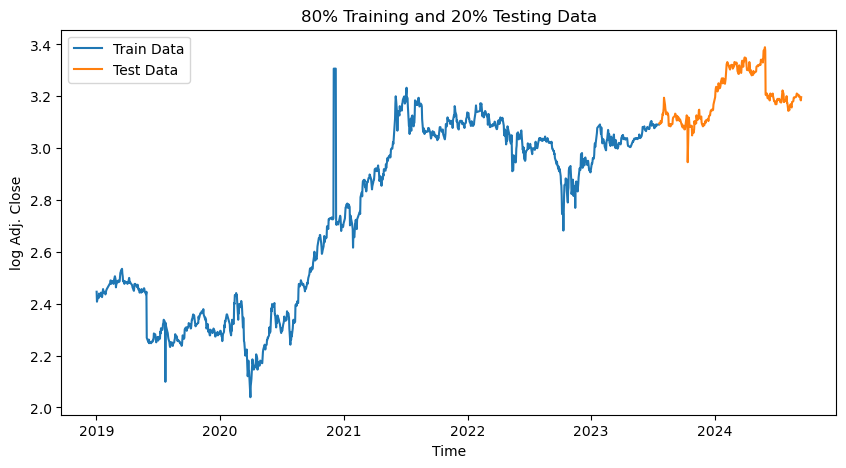

In [11]:
# Assuming ACB DataFrame is already defined and contains the necessary columns

# Calculate the cutoff index for 80% training and 20% testing
cutoff_index = int(len(ACB) * 0.8)

# Split the data into training and testing datasets
ACB_Train_Data = ACB.iloc[:cutoff_index]
ACB_Test_Data = ACB.iloc[cutoff_index:].reset_index(drop=True)

print(ACB_Test_Data.shape)
# Plot the train and test data
plt.figure(figsize=(10, 5))
plt.plot(ACB_Train_Data['Date'], ACB_Train_Data['log Adj. Close'], label='Train Data')
plt.plot(ACB_Test_Data['Date'], ACB_Test_Data['log Adj. Close'], label='Test Data')
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.title('80% Training and 20% Testing Data')
plt.legend(loc='best')
plt.show()


###Modeling

In [12]:
ACB_Auto_ARIMA_Model = auto_arima(ACB_Train_Data['log Adj. Close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(ACB_Auto_ARIMA_Model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1141
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2279.579
Date:                Wed, 18 Sep 2024   AIC                          -4557.158
Time:                        09:59:46   BIC                          -4552.119
Sample:                             0   HQIC                         -4555.255
                               - 1141                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0011   4.78e-06    224.277      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   1.66   Jarque-Bera (JB):           1446689.01
Prob(Q):                              0.20   Pr

In [13]:
from statsmodels.tsa.arima.model import ARIMA  # Correct import

# Fit ARIMA model
ACB_ARIMA_Model = ARIMA(ACB_Train_Data['log Adj. Close'], order=(1, 0, 1))
ACB_ARIMA_Model_Fit = ACB_ARIMA_Model.fit()

# Print the summary of the model
print(ACB_ARIMA_Model_Fit.summary())


                               SARIMAX Results                                
Dep. Variable:         log Adj. Close   No. Observations:                 1141
Model:                 ARIMA(1, 0, 1)   Log Likelihood                2281.328
Date:                Wed, 18 Sep 2024   AIC                          -4554.656
Time:                        09:59:46   BIC                          -4534.498
Sample:                             0   HQIC                         -4547.044
                               - 1141                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7417      0.206     13.294      0.000       2.337       3.146
ar.L1          0.9957      0.003    313.603      0.000       0.990       1.002
ma.L1         -0.0354      0.020     -1.799      0.0

### Predicting the closing stock price of ACB

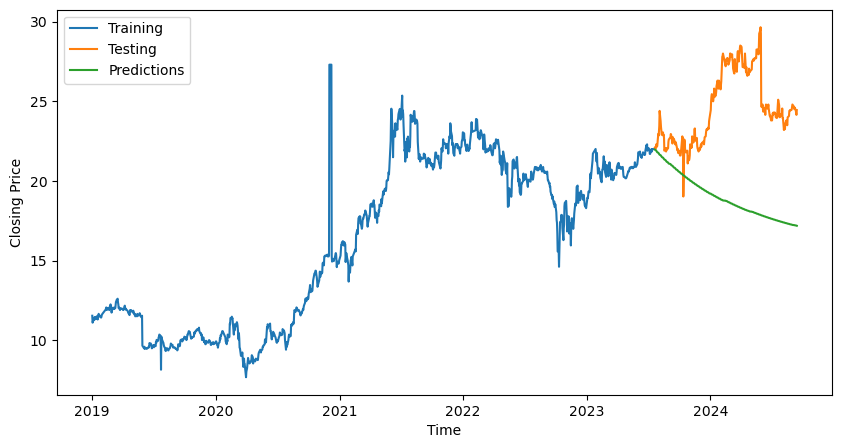

In [14]:
ACB_output = ACB_ARIMA_Model_Fit.forecast(286, alpha=0.05)
ACB_predictions = np.exp(ACB_output)
plt.figure(figsize=(10, 5))
plt.plot(ACB_Train_Data['Date'], ACB_Train_Data['Adj. Close'], label = 'Training')
plt.plot(ACB_Test_Data['Date'], ACB_Test_Data['Adj. Close'], label = 'Testing')
plt.plot(ACB_Test_Data['Date'], ACB_predictions, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

In [15]:

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(ACB_Test_Data['Adj. Close'], ACB_predictions))

# Filter out non-zero values for 'Adj. Close'
non_zero_mask = ACB_Test_Data['Adj. Close'] != 0
ACB_Test_Non_Zero = ACB_Test_Data.loc[non_zero_mask]
ACB_Predictions_Non_Zero = ACB_predictions.values[non_zero_mask]  # Use .values to directly access values

# Recalculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs(ACB_Predictions_Non_Zero - ACB_Test_Non_Zero['Adj. Close'].values) / np.abs(ACB_Test_Non_Zero['Adj. Close'].values))

# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(ACB_Test_Non_Zero['Adj. Close'], ACB_Predictions_Non_Zero)

# Calculate SEM (Standard Error of the Mean)
sem = np.std(ACB_Test_Non_Zero['Adj. Close'] - ACB_Predictions_Non_Zero) / np.sqrt(len(ACB_Test_Non_Zero))

# Print all metrics
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'MAE: {mae}')
print(f'SEM: {sem}')


RMSE: 6.342788228109719
MAPE: 0.21594612333715002
MAE: 5.5095291534248485
SEM: 0.18678222852646095


# BIDV

In [16]:
BIDV.head()

,Date,Open,High,Low,Adj. Close,Volume
0,2019-01-02,22.968,22.968,22.334,22.367,805700.0
1,2019-01-03,22.367,22.568,21.366,21.366,1107500.0
2,2019-01-04,21.032,21.333,20.565,21.065,1457300.0
3,2019-01-07,21.366,22.034,21.366,21.566,806060.0
4,2019-01-08,21.767,21.767,21.299,21.366,558540.0


In [17]:
BIDV.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1422 entries, 0 to 1421
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1422 non-null   object 
 1   Open        1422 non-null   float64
 2   High        1422 non-null   float64
 3   Low         1422 non-null   float64
 4   Adj. Close  1422 non-null   float64
 5   Volume      1422 non-null   float64
dtypes: float64(5), object(1)
memory usage: 66.8+ KB


In [18]:
# Change Dtype of Date column
BIDV["Date"] = pd.to_datetime(BIDV["Date"])

In [19]:
Test_Stationarity(BIDV)

Results of Dickey Fuller Test
Test Statistics: -1.402706370717914
p-value: 0.5809779648265687
Number of lags used: 5
Number of observations used: 1416
critical value (1%): -3.434976549531161
critical value (5%): -2.86358329808087
critical value (10%): -2.5678578416363433


The p-value > 0.05, so we cannot reject the Null hypothesis. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series, to make the data stationary while building the Auto ARIMA model.

Now let's take log of the 'Adj. Close' column to reduce the magnitude of the values and reduce the series rising trend.

Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

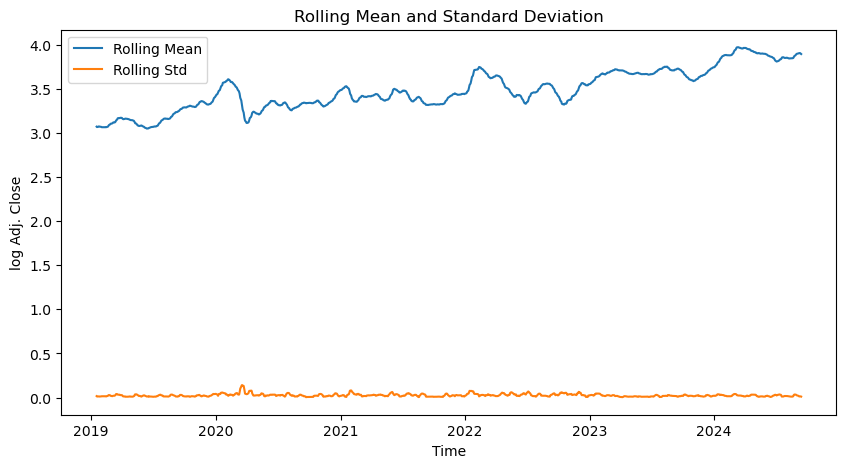

In [20]:
BIDV['log Adj. Close'] = np.log(BIDV['Adj. Close'])
BIDV_log_moving_avg = BIDV['log Adj. Close'].rolling(12).mean()
BIDV_log_std = BIDV['log Adj. Close'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(BIDV['Date'], BIDV_log_moving_avg, label = "Rolling Mean")
plt.plot(BIDV['Date'], BIDV_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

###Split the data into training and test set
    Training Period: 2015-01-02 - 2020-09-30

    Testing Period:  2020-10-01 - 2021-02-26

(285, 7)


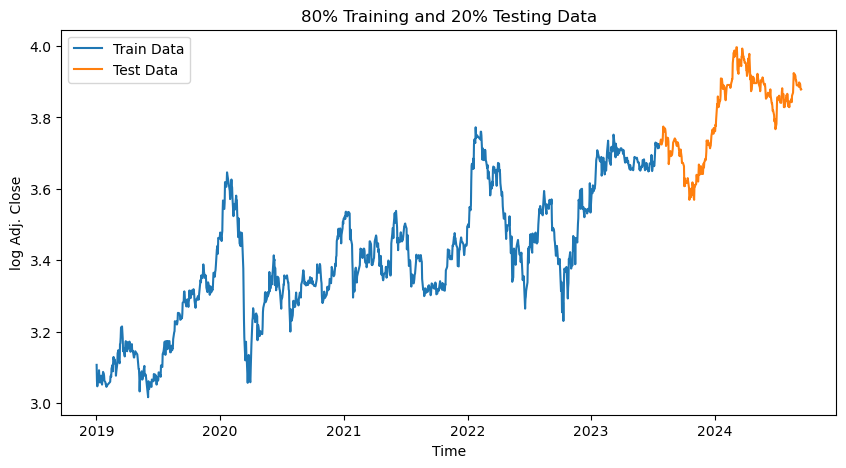

In [21]:


# Assuming ACB DataFrame is already defined and contains the necessary columns

# Calculate the cutoff index for 80% training and 20% testing
cutoff_index = int(len(BIDV) * 0.8)

# Split the data into training and testing datasets
BIDV_Train_Data = BIDV.iloc[:cutoff_index]
BIDV_Test_Data = BIDV.iloc[cutoff_index:].reset_index(drop=True)

print(BIDV_Test_Data.shape)
# Plot the train and test data
plt.figure(figsize=(10, 5))
plt.plot(BIDV_Train_Data['Date'], BIDV_Train_Data['log Adj. Close'], label='Train Data')
plt.plot(BIDV_Test_Data['Date'], BIDV_Test_Data['log Adj. Close'], label='Test Data')
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.title('80% Training and 20% Testing Data')
plt.legend(loc='best')
plt.show()

###Modeling

In [22]:
BIDV_Auto_ARIMA_Model = auto_arima(BIDV_Train_Data['log Adj. Close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(BIDV_Auto_ARIMA_Model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1137
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2713.946
Date:                Wed, 18 Sep 2024   AIC                          -5425.892
Time:                        09:59:47   BIC                          -5420.856
Sample:                             0   HQIC                         -5423.990
                               - 1137                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0005   1.49e-05     32.999      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   0.66   Jarque-Bera (JB):               181.09
Prob(Q):                              0.41   Pr

In [23]:
BIDV_ARIMA_Model = ARIMA(BIDV_Train_Data['log Adj. Close'], order = (5, 2, 2))
BIDV_ARIMA_Model_Fit = BIDV_ARIMA_Model.fit()
print(BIDV_ARIMA_Model_Fit.summary())

                               SARIMAX Results                                
Dep. Variable:         log Adj. Close   No. Observations:                 1137
Model:                 ARIMA(5, 2, 2)   Log Likelihood                2704.892
Date:                Wed, 18 Sep 2024   AIC                          -5393.784
Time:                        09:59:48   BIC                          -5353.509
Sample:                             0   HQIC                         -5378.571
                               - 1137                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7555      0.222     -3.409      0.001      -1.190      -0.321
ar.L2         -0.0464      0.031     -1.505      0.132      -0.107       0.014
ar.L3         -0.0125      0.034     -0.362      0.7

### Predicting the closing stock price of Tesla

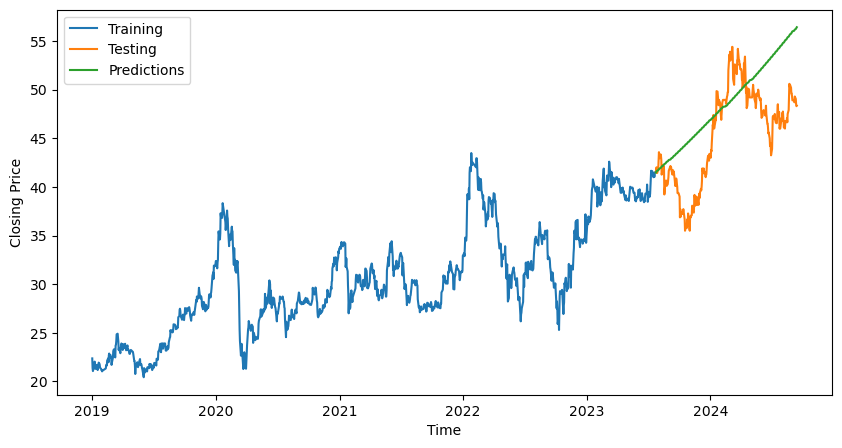

In [25]:
BIDV_output = BIDV_ARIMA_Model_Fit.forecast(285, alpha=0.05)
BIDV_predictions = np.exp(BIDV_output)
plt.figure(figsize=(10, 5))
plt.plot(BIDV_Train_Data['Date'], BIDV_Train_Data['Adj. Close'], label = 'Training')
plt.plot(BIDV_Test_Data['Date'], BIDV_Test_Data['Adj. Close'], label = 'Testing')
plt.plot(BIDV_Test_Data['Date'], BIDV_predictions, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

In [26]:

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(BIDV_Test_Data['Adj. Close'], BIDV_predictions))

# Calculate MAPE (Mean Absolute Percentage Error)
non_zero_mask = BIDV_Test_Data['Adj. Close'] != 0
BIDV_Test_Non_Zero = BIDV_Test_Data.loc[non_zero_mask]
BIDV_Predictions_Non_Zero = BIDV_predictions.values[non_zero_mask]  # Use .values to directly access values

# Recalculate MAPE
mape = np.mean(np.abs(BIDV_Predictions_Non_Zero - BIDV_Test_Non_Zero['Adj. Close'].values) / np.abs(BIDV_Test_Non_Zero['Adj. Close'].values))

# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(BIDV_Test_Non_Zero['Adj. Close'], BIDV_Predictions_Non_Zero)

# Calculate SEM (Standard Error of the Mean)
sem = np.std(BIDV_Test_Non_Zero['Adj. Close'] - BIDV_Predictions_Non_Zero) / np.sqrt(len(BIDV_Test_Non_Zero))

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'MAE: {mae}')
print(f'SEM: {sem}')

RMSE: 5.102233459680539
MAPE: 0.0982147243187435
MAE: 4.280324309468751
SEM: 0.2284985194302768


# BVH

In [27]:
BVH.head()

,Date,Open,High,Low,Adj. Close,Volume
0,2019-01-02,79.787,79.787,78.119,78.119,87080.0
1,2019-01-03,79.436,79.875,77.593,78.295,55310.0
2,2019-01-04,78.295,78.295,75.486,77.768,96940.0
3,2019-01-07,78.558,79.699,76.978,77.768,92970.0
4,2019-01-08,77.768,77.768,77.241,77.417,36610.0


In [28]:
BVH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1422 entries, 0 to 1421
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1422 non-null   object 
 1   Open        1422 non-null   float64
 2   High        1422 non-null   float64
 3   Low         1422 non-null   float64
 4   Adj. Close  1422 non-null   float64
 5   Volume      1422 non-null   float64
dtypes: float64(5), object(1)
memory usage: 66.8+ KB


In [29]:
# Change Dtype of Date column
BVH["Date"] = pd.to_datetime(BVH["Date"])

In [30]:
Test_Stationarity(BVH)

Results of Dickey Fuller Test
Test Statistics: -2.598356002561067
p-value: 0.09333752455170624
Number of lags used: 1
Number of observations used: 1420
critical value (1%): -3.4349634933241084
critical value (5%): -2.8635775363009244
critical value (10%): -2.5678547733584605


The p-value > 0.05, so we cannot reject the Null hypothesis. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series, to make the data stationary while building the Auto ARIMA model.

Now let's take log of the 'Adj. Close' column to reduce the magnitude of the values and reduce the series rising trend.

Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

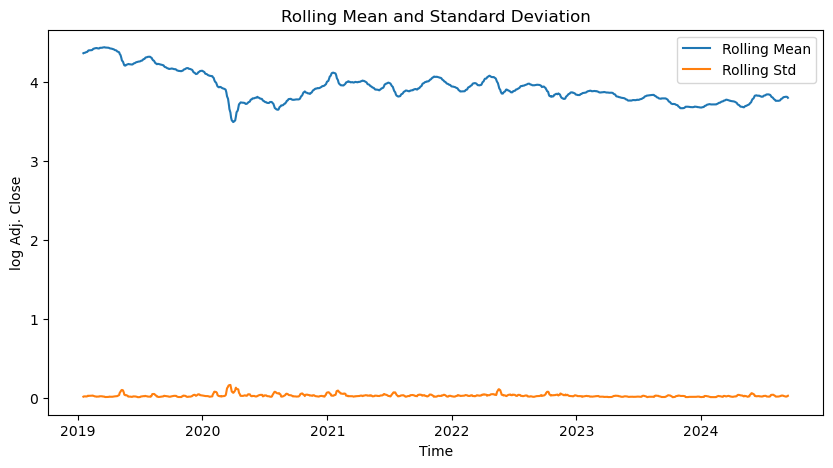

In [31]:
BVH['log Adj. Close'] = np.log(BVH['Adj. Close'])
BVH_log_moving_avg = BVH['log Adj. Close'].rolling(12).mean()
BVH_log_std = BVH['log Adj. Close'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(BVH['Date'], BVH_log_moving_avg, label = "Rolling Mean")
plt.plot(BVH['Date'], BVH_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

### Split the data into training and test set
   

(285, 7)


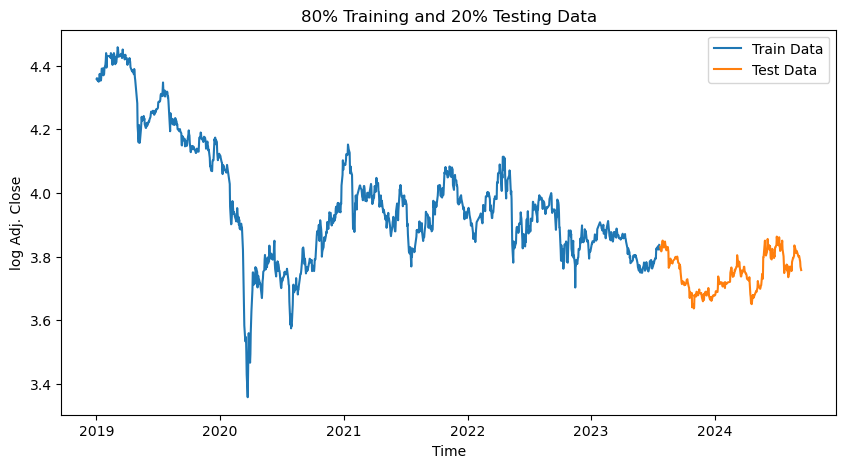

In [32]:

# Assuming ACB DataFrame is already defined and contains the necessary columns

# Calculate the cutoff index for 80% training and 20% testing
cutoff_index = int(len(BVH) * 0.8)

# Split the data into training and testing datasets
BVH_Train_Data = BVH.iloc[:cutoff_index]
BVH_Test_Data = BVH.iloc[cutoff_index:].reset_index(drop=True)

print(BVH_Test_Data.shape)
# Plot the train and test data
plt.figure(figsize=(10, 5))
plt.plot(BVH_Train_Data['Date'], BVH_Train_Data['log Adj. Close'], label='Train Data')
plt.plot(BVH_Test_Data['Date'], BVH_Test_Data['log Adj. Close'], label='Test Data')
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.title('80% Training and 20% Testing Data')
plt.legend(loc='best')
plt.show()

### Modeling

In [33]:
BVH_Auto_ARIMA_Model = auto_arima(BVH_Train_Data['log Adj. Close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)

print(BVH_Auto_ARIMA_Model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1137
Model:               SARIMAX(0, 1, 1)   Log Likelihood                2724.841
Date:                Wed, 18 Sep 2024   AIC                          -5445.681
Time:                        10:00:03   BIC                          -5435.611
Sample:                             0   HQIC                         -5441.878
                               - 1137                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0852      0.020      4.289      0.000       0.046       0.124
sigma2         0.0005   1.49e-05     32.476      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [34]:

# Thử với order (p=1, d=1, q=1)
BVH_ARIMA_Model = ARIMA(BVH_Train_Data['log Adj. Close'], order=(1, 2, 1))
BVH_ARIMA_Model_Fit = BVH_ARIMA_Model.fit()
print(BVH_ARIMA_Model_Fit.summary())


                               SARIMAX Results                                
Dep. Variable:         log Adj. Close   No. Observations:                 1137
Model:                 ARIMA(1, 2, 1)   Log Likelihood                2718.698
Date:                Wed, 18 Sep 2024   AIC                          -5431.396
Time:                        10:00:03   BIC                          -5416.293
Sample:                             0   HQIC                         -5425.692
                               - 1137                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0850      0.019      4.447      0.000       0.048       0.122
ma.L1         -0.9999      0.085    -11.743      0.000      -1.167      -0.833
sigma2         0.0005   4.39e-05     10.999      0.0

### Predicting the closing stock price of BVH

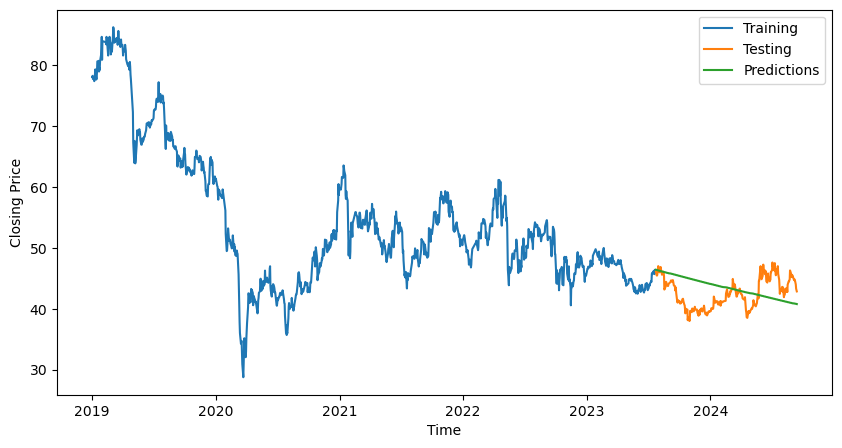

In [35]:
BVH_output = BVH_ARIMA_Model_Fit.forecast(285, alpha=0.05)
BVH_predictions = np.exp(BVH_output)
plt.figure(figsize=(10, 5))
plt.plot(BVH_Train_Data['Date'], BVH_Train_Data['Adj. Close'], label = 'Training')
plt.plot(BVH_Test_Data['Date'], BVH_Test_Data['Adj. Close'], label = 'Testing')
plt.plot(BVH_Test_Data['Date'], BVH_predictions, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

In [36]:

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(BVH_Test_Data['Adj. Close'], BVH_predictions))

# Calculate MAPE (Mean Absolute Percentage Error)
non_zero_mask = BVH_Test_Data['Adj. Close'] != 0
BVH_Test_Non_Zero = BVH_Test_Data.loc[non_zero_mask]
BVH_Predictions_Non_Zero = BVH_predictions.values[non_zero_mask]  # Use .values to directly access values

# Recalculate MAPE
mape = np.mean(np.abs(BVH_Predictions_Non_Zero - BVH_Test_Non_Zero['Adj. Close'].values) / np.abs(BVH_Test_Non_Zero['Adj. Close'].values))
# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(BVH_Test_Non_Zero['Adj. Close'], BVH_Predictions_Non_Zero)

# Calculate SEM (Standard Error of the Mean)
sem = np.std(BVH_Test_Non_Zero['Adj. Close'] - BVH_Predictions_Non_Zero) / np.sqrt(len(BVH_Test_Non_Zero))
print(f'MAE: {mae}')
print(f'SEM: {sem}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')


MAE: 2.909196440760706
SEM: 0.19304218391315564
RMSE: 3.396924617005604
MAPE: 0.06939743290557264


# Vietinbank

In [37]:
CTG.head()

,Date,Open,High,Low,Adj. Close,Volume
0,2019-01-02,12.844,12.978,12.677,12.677,2420340.0
1,2019-01-03,12.677,12.811,12.043,12.077,5513360.0
2,2019-01-04,12.043,12.377,11.810,12.244,3804290.0
3,2019-01-07,12.544,12.544,12.110,12.110,3982660.0
4,2019-01-08,12.177,12.177,11.877,11.943,5636280.0


In [38]:
CTG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1422 entries, 0 to 1421
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1422 non-null   object 
 1   Open        1422 non-null   float64
 2   High        1422 non-null   float64
 3   Low         1422 non-null   float64
 4   Adj. Close  1422 non-null   float64
 5   Volume      1422 non-null   float64
dtypes: float64(5), object(1)
memory usage: 66.8+ KB


In [39]:
# Change Dtype of Date column
CTG["Date"] = pd.to_datetime(CTG["Date"])

In [40]:
Test_Stationarity(CTG)

Results of Dickey Fuller Test
Test Statistics: -1.3761977387688373
p-value: 0.5936325425261969
Number of lags used: 5
Number of observations used: 1416
critical value (1%): -3.434976549531161
critical value (5%): -2.86358329808087
critical value (10%): -2.5678578416363433


The p-value > 0.05, so we cannot reject the Null hypothesis. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series, to make the data stationary while building the Auto ARIMA model.

Now let's take log of the 'Adj. Close' column to reduce the magnitude of the values and reduce the series rising trend.

Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

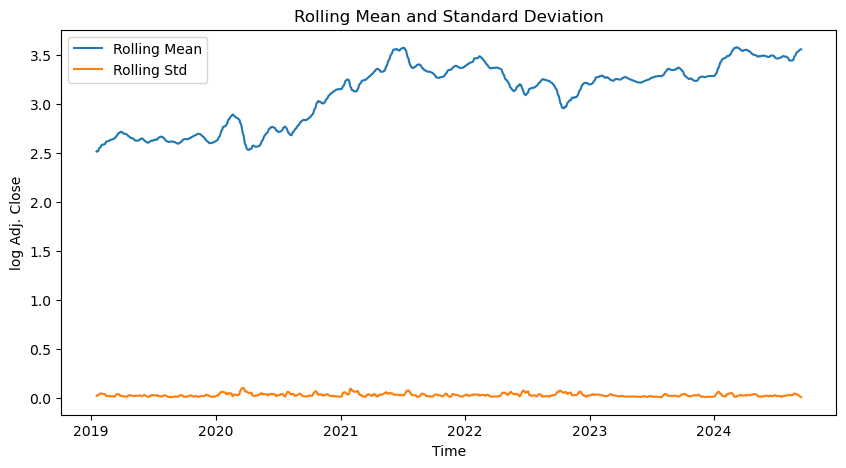

In [41]:
CTG['log Adj. Close'] = np.log(CTG['Adj. Close'])
CTG_log_moving_avg = CTG['log Adj. Close'].rolling(12).mean()
CTG_log_std = CTG['log Adj. Close'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(CTG['Date'], CTG_log_moving_avg, label = "Rolling Mean")
plt.plot(CTG['Date'], CTG_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

### Split the data into training and test set


(285, 7)


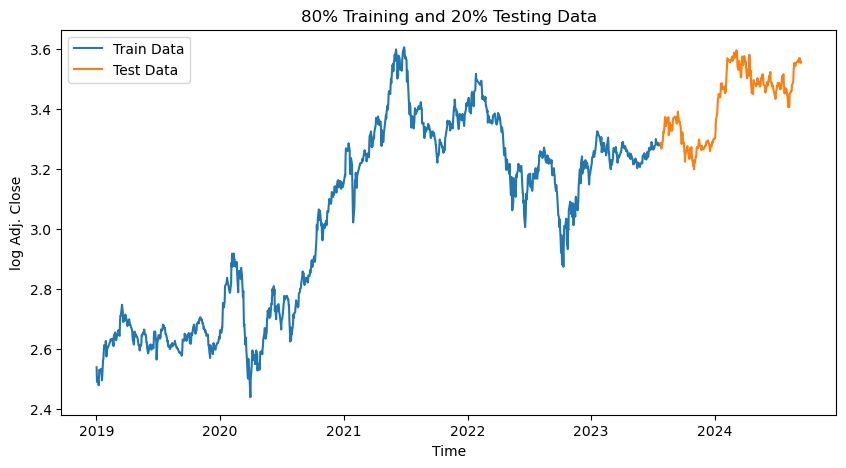

In [42]:

# Calculate the cutoff index for 80% training and 20% testing
cutoff_index = int(len(CTG) * 0.8)

# Split the data into training and testing datasets
CTG_Train_Data = CTG.iloc[:cutoff_index]
CTG_Test_Data = CTG.iloc[cutoff_index:].reset_index(drop=True)

print(CTG_Test_Data.shape)
# Plot the train and test data
plt.figure(figsize=(10, 5))
plt.plot(CTG_Train_Data['Date'], CTG_Train_Data['log Adj. Close'], label='Train Data')
plt.plot(CTG_Test_Data['Date'], CTG_Test_Data['log Adj. Close'], label='Test Data')
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.title('80% Training and 20% Testing Data')
plt.legend(loc='best')
plt.show()

### Modeling

In [43]:
CTG_Auto_ARIMA_Model = auto_arima(CTG_Train_Data['log Adj. Close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(CTG_Auto_ARIMA_Model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1137
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2698.653
Date:                Wed, 18 Sep 2024   AIC                          -5395.307
Time:                        10:00:04   BIC                          -5390.271
Sample:                             0   HQIC                         -5393.405
                               - 1137                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0005   1.52e-05     33.194      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   1.84   Jarque-Bera (JB):               182.43
Prob(Q):                              0.18   Pr

In [44]:
from statsmodels.tsa.arima.model import ARIMA
CTG_ARIMA_Model = ARIMA(CTG_Train_Data['log Adj. Close'], order=(1, 3, 1))
CTG_ARIMA_Model_Fit = CTG_ARIMA_Model.fit()
print(CTG_ARIMA_Model_Fit.summary())


                               SARIMAX Results                                
Dep. Variable:         log Adj. Close   No. Observations:                 1137
Model:                 ARIMA(1, 3, 1)   Log Likelihood                2449.197
Date:                Wed, 18 Sep 2024   AIC                          -4892.394
Time:                        10:00:05   BIC                          -4877.294
Sample:                             0   HQIC                         -4886.690
                               - 1137                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5139      0.021    -23.997      0.000      -0.556      -0.472
ma.L1         -0.9997      0.170     -5.890      0.000      -1.332      -0.667
sigma2         0.0008      0.000      5.674      0.0

### Predicting the closing stock price of Vietinbank

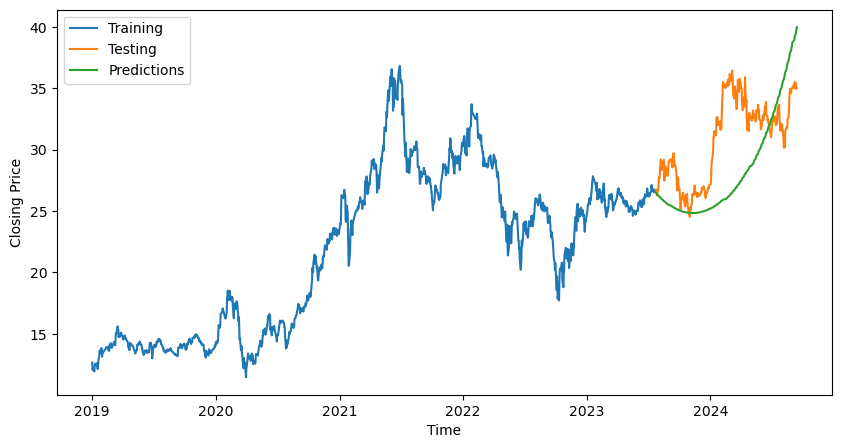

In [45]:
CTG_output = CTG_ARIMA_Model_Fit.forecast(285, alpha=0.05)
CTG_predictions = np.exp(CTG_output)
plt.figure(figsize=(10, 5))
plt.plot(CTG_Train_Data['Date'], CTG_Train_Data['Adj. Close'], label = 'Training')
plt.plot(CTG_Test_Data['Date'], CTG_Test_Data['Adj. Close'], label = 'Testing')
plt.plot(CTG_Test_Data['Date'], CTG_predictions, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

In [46]:

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(CTG_Test_Data['Adj. Close'], CTG_predictions))

# Calculate MAPE (Mean Absolute Percentage Error)
non_zero_mask = CTG_Test_Data['Adj. Close'] != 0
CTG_Test_Non_Zero = CTG_Test_Data.loc[non_zero_mask]
CTG_Predictions_Non_Zero = CTG_predictions.values[non_zero_mask]  # Use .values to directly access values

# Recalculate MAPE
mape = np.mean(np.abs(CTG_Predictions_Non_Zero - CTG_Test_Non_Zero['Adj. Close'].values) / np.abs(CTG_Test_Non_Zero['Adj. Close'].values)*100)
# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(CTG_Test_Non_Zero['Adj. Close'], CTG_Predictions_Non_Zero)

# Calculate SEM (Standard Error of the Mean)
sem = np.std(CTG_Test_Non_Zero['Adj. Close'] - CTG_Predictions_Non_Zero) / np.sqrt(len(CTG_Test_Non_Zero))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'MAE: {mae}')
print(f'SEM: {sem}')

RMSE: 4.348620475323759
MAPE: 10.90153213615762
MAE: 3.5004575454784295
SEM: 0.21660642135791566


# FPT

In [47]:
FPT.head()

,Date,Open,High,Low,Adj. Close,Volume
0,2019-01-02,18.247,18.400,17.964,17.985,459120.0
1,2019-01-03,18.095,18.095,17.767,17.811,716600.0
2,2019-01-04,17.723,18.095,17.680,17.942,318570.0
3,2019-01-07,18.247,18.378,18.160,18.247,408470.0
4,2019-01-08,18.247,18.335,18.204,18.335,295660.0


In [48]:
FPT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1422 entries, 0 to 1421
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1422 non-null   object 
 1   Open        1422 non-null   float64
 2   High        1422 non-null   float64
 3   Low         1422 non-null   float64
 4   Adj. Close  1422 non-null   float64
 5   Volume      1422 non-null   float64
dtypes: float64(5), object(1)
memory usage: 66.8+ KB


In [49]:
# Change Dtype of Date column
FPT["Date"] = pd.to_datetime(FPT["Date"])

In [50]:
Test_Stationarity(FPT)

Results of Dickey Fuller Test
Test Statistics: 2.087532216025943
p-value: 0.9987764349240807
Number of lags used: 21
Number of observations used: 1400
critical value (1%): -3.435029521805029
critical value (5%): -2.8636066747959186
critical value (10%): -2.5678702903061223


The p-value > 0.05, so we cannot reject the Null hypothesis. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series, to make the data stationary while building the Auto ARIMA model.

Now let's take log of the 'Adj. Close' column to reduce the magnitude of the values and reduce the series rising trend.

Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

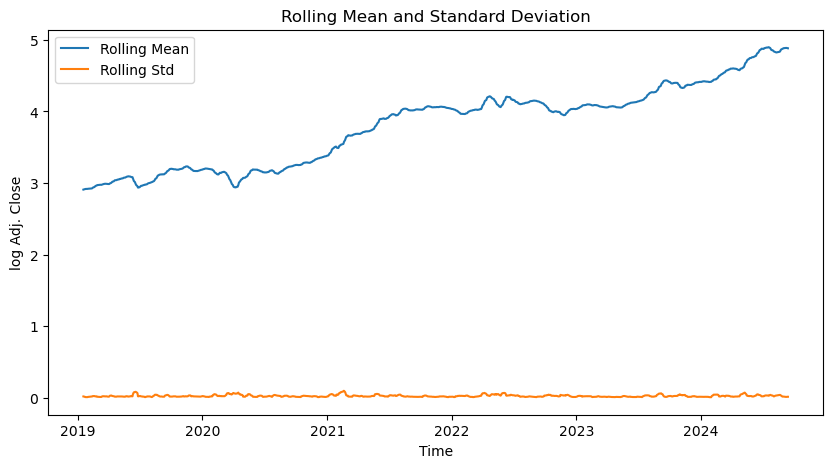

In [51]:
FPT['log Adj. Close'] = np.log(FPT['Adj. Close'])
FPT_log_moving_avg = FPT['log Adj. Close'].rolling(12).mean()
FPT_log_std = FPT['log Adj. Close'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(FPT['Date'], FPT_log_moving_avg, label = "Rolling Mean")
plt.plot(FPT['Date'], FPT_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

### Split the data into training and test set
    

(285, 7)


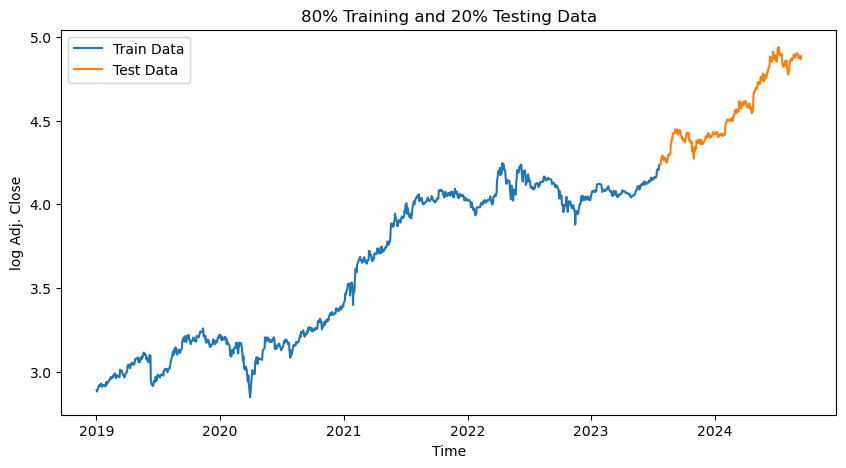

In [52]:

# Calculate the cutoff index for 80% training and 20% testing
cutoff_index = int(len(FPT) * 0.8)

# Split the data into training and testing datasets
FPT_Train_Data = FPT.iloc[:cutoff_index]
FPT_Test_Data = FPT.iloc[cutoff_index:].reset_index(drop=True)

print(FPT_Test_Data.shape)
# Plot the train and test data
plt.figure(figsize=(10, 5))
plt.plot(FPT_Train_Data['Date'], FPT_Train_Data['log Adj. Close'], label='Train Data')
plt.plot(FPT_Test_Data['Date'], FPT_Test_Data['log Adj. Close'], label='Test Data')
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.title('80% Training and 20% Testing Data')
plt.legend(loc='best')
plt.show()

### Modeling

In [53]:
FPT_Auto_ARIMA_Model = auto_arima(FPT_Train_Data['log Adj. Close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(FPT_Auto_ARIMA_Model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1137
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2962.833
Date:                Wed, 18 Sep 2024   AIC                          -5921.666
Time:                        10:00:06   BIC                          -5911.596
Sample:                             0   HQIC                         -5917.862
                               - 1137                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012      0.001      2.173      0.030       0.000       0.002
sigma2         0.0003   6.14e-06     51.776      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.11   Jarque-

In [54]:

FPT_ARIMA_Model = ARIMA(FPT_Train_Data['log Adj. Close'], order=(1, 2, 1))  # Example order
FPT_ARIMA_Model_Fit = FPT_ARIMA_Model.fit()
print(FPT_ARIMA_Model_Fit.summary())


                               SARIMAX Results                                
Dep. Variable:         log Adj. Close   No. Observations:                 1137
Model:                 ARIMA(1, 2, 1)   Log Likelihood                2956.269
Date:                Wed, 18 Sep 2024   AIC                          -5906.538
Time:                        10:00:06   BIC                          -5891.435
Sample:                             0   HQIC                         -5900.834
                               - 1137                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0107      0.022      0.484      0.628      -0.032       0.054
ma.L1         -1.0000      0.253     -3.948      0.000      -1.496      -0.504
sigma2         0.0003   8.03e-05      3.959      0.0

### Predicting the closing stock price of FPT

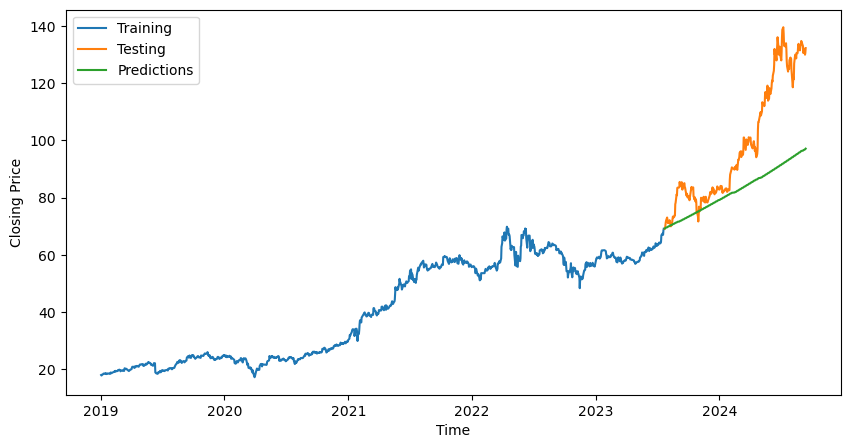

In [55]:
FPT_output = FPT_ARIMA_Model_Fit.forecast(285, alpha=0.05)
FPT_predictions = np.exp(FPT_output)
plt.figure(figsize=(10, 5))
plt.plot(FPT_Train_Data['Date'], FPT_Train_Data['Adj. Close'], label = 'Training')
plt.plot(FPT_Test_Data['Date'], FPT_Test_Data['Adj. Close'], label = 'Testing')
plt.plot(FPT_Test_Data['Date'], FPT_predictions, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

In [56]:

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(FPT_Test_Data['Adj. Close'], FPT_predictions))

# Calculate MAPE (Mean Absolute Percentage Error)
non_zero_mask = FPT_Test_Data['Adj. Close'] != 0
FPT_Test_Non_Zero = FPT_Test_Data.loc[non_zero_mask]
FPT_Predictions_Non_Zero = FPT_predictions.values[non_zero_mask]  # Use .values to directly access values

# Recalculate MAPE
mape = np.mean(np.abs(FPT_Predictions_Non_Zero - FPT_Test_Non_Zero['Adj. Close'].values) / np.abs(FPT_Test_Non_Zero['Adj. Close'].values)*100)
# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(FPT_Test_Non_Zero['Adj. Close'], FPT_Predictions_Non_Zero)

# Calculate SEM (Standard Error of the Mean)
sem = np.std(FPT_Test_Non_Zero['Adj. Close'] - FPT_Predictions_Non_Zero) / np.sqrt(len(FPT_Test_Non_Zero))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'MAE: {mae}')
print(f'SEM: {sem}')

RMSE: 21.025925635567617
MAPE: 14.020460948224226
MAE: 15.830345312153934
SEM: 0.8232921192009784
